## Import Lib

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from zkyhaxpy import io_tools, gis_tools, pd_tools
import rasterio
import os
import shutil
import numpy as np
from tqdm.notebook import tqdm
import aqi
import numpy as np
from scipy import stats


## Define constants

In [25]:

aqi_color_codes = {
        -9:"Grey",
        0: "Green",
        1: "Yellow",
        2: "Orange",
        3: "Red",
        4: "Purple",
        5: "Maroon"
    }    


## Define functions

### pm25_to_aqi_level

In [26]:


def pm25_to_aqi_level(pm25_concentration: float) -> int:
    """
    Converts PM2.5 concentration to AQI class (as integer).

    Args:
        pm25_concentration (float): PM2.5 concentration in µg/m³.

    Returns:
        int: AQI level (0 to 5) based on EPA guidelines.
    """
    aqi_value = aqi.to_aqi([(aqi.POLLUTANT_PM25, str(pm25_concentration))])
    if aqi_value <= 50:
        return 0  # Good
    elif 50 < aqi_value <= 100:
        return 1  # Moderate
    elif 100 < aqi_value <= 150:
        return 2  # Unhealthy for Sensitive Groups
    elif 150 < aqi_value <= 200:
        return 3  # Unhealthy
    elif 200 < aqi_value <= 300:
        return 4  # Very Unhealthy
    else:
        return 5  # Hazardous


### aqi_level_to_color

In [27]:

def aqi_level_to_color(aqi_class: int) -> str:
    """
    Converts AQI level (as integer) to color code.

    Args:
        aqi_class (int): AQI level (0 to 5).

    Returns:
        str: Color code corresponding to the AQI level.
    """
    color_codes = {
        0: "Green",
        1: "Yellow",
        2: "Orange",
        3: "Red",
        4: "Purple",
        5: "Maroon"
    }
    return color_codes.get(aqi_class, "Unknown")


## Load data for training model

In [28]:
df_chiangmai_grid = pd.read_parquet(r'../data/df_chiangmai_grid.parquet')

lat_min = df_chiangmai_grid.lat.min()
lat_max = df_chiangmai_grid.lat.max()
lon_min = df_chiangmai_grid.lon.min()
lon_max = df_chiangmai_grid.lon.max()

In [29]:
df_extracted_aod055 = pd.read_csv(r'../data/df_extracted_openaq_aod055_v2.csv')
del(df_extracted_aod055['row'])
del(df_extracted_aod055['col'])
del(df_extracted_aod055['tile_id'])

df_extracted_dem = pd.read_csv(r'../data/df_extracted_openaq_dem_v2.csv')
del(df_extracted_dem['row'])
del(df_extracted_dem['col'])


path_df_openaq = r'../data/gdf_openaq_chiangmai_by_location.parquet'
if os.path.exists(path_df_openaq):
    df_openaq = pd.read_parquet(path_df_openaq)
    print(f'{path_df_openaq} has been loaded')
else:
    gdf_openaq = gpd.read_file('../data/gdf_openaq_chiangmai_by_location.gpkg')
    print('gdf_openaq has been loaded.')
    if gdf_openaq.index.name is None:
        gdf_openaq = gdf_openaq.set_index('measurement_id')
    
    df_openaq = gdf_openaq.drop(columns=['geometry']).copy()
    df_openaq.to_parquet(path_df_openaq)
    print(f'{path_df_openaq} has been saved')

../data/gdf_openaq_chiangmai_by_location.parquet has been loaded


In [30]:
df_openaq = df_openaq[df_openaq['value'] != -999].copy()
df_openaq

,locationId,location,parameter,value,date,unit,country,city,isMobile,isAnalysis,entity,sensorType,datetime,year,month,year_month,time,lat,lon
measurement_id,,,,,,,,,,,,,,,,,,,
0,1235996,"Vieng Nua, Pai",pm25,2.191964,2023-10-31,µg/m³,TH,None,False,None,Governmental Organization,low-cost sensor,2023-10-31T00:00,2023,0-,2023-10-,00:00,19.374620,98.445611
1,1235996,"Vieng Nua, Pai",pm25,2.313988,2023-10-30,µg/m³,TH,None,False,None,Governmental Organization,low-cost sensor,2023-10-30T23:00,2023,0-,2023-10-,23:00,19.374620,98.445611
2,1235996,"Vieng Nua, Pai",pm25,2.580357,2023-10-30,µg/m³,TH,None,False,None,Governmental Organization,low-cost sensor,2023-10-30T22:00,2023,0-,2023-10-,22:00,19.374620,98.445611
3,1235996,"Vieng Nua, Pai",pm25,3.220238,2023-10-30,µg/m³,TH,None,False,None,Governmental Organization,low-cost sensor,2023-10-30T21:00,2023,0-,2023-10-,21:00,19.374620,98.445611
4,1235996,"Vieng Nua, Pai",pm25,3.644345,2023-10-30,µg/m³,TH,None,False,None,Governmental Organization,low-cost sensor,2023-10-30T20:00,2023,0-,2023-10-,20:00,19.374620,98.445611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253632,523937,Tha Kham Municipality Office,pm25,9.600000,2023-06-01,µg/m³,TH,None,False,None,Governmental Organization,reference grade,2023-06-01T06:00,2023,6-,2023-06-,06:00,18.202222,98.597222
253633,523937,Tha Kham Municipality Office,pm25,9.700000,2023-06-01,µg/m³,TH,None,False,None,Governmental Organization,reference grade,2023-06-01T05:00,2023,6-,2023-06-,05:00,18.202222,98.597222
253634,523937,Tha Kham Municipality Office,pm25,9.800000,2023-06-01,µg/m³,TH,None,False,None,Governmental Organization,reference grade,2023-06-01T04:00,2023,6-,2023-06-,04:00,18.202222,98.597222


In [31]:
df_openaq['locationId'].nunique()

73

In [32]:
df_extracted_aod055 = df_extracted_aod055[df_extracted_aod055['aod_055'] >= 0].copy()
df_extracted_aod055 = df_extracted_aod055.set_index('measurement_id')
df_extracted_aod055

,aod_055,aod_datetime
measurement_id,,
157249,632.0,2022-04-19 07:05:00+00:00
157250,632.0,2022-04-19 07:05:00+00:00
205094,357.0,2022-04-19 07:05:00+00:00
205095,357.0,2022-04-19 07:05:00+00:00
118040,177.0,2023-01-21 07:45:00+00:00
...,...,...
235082,248.0,2024-03-09 07:35:00+00:00
245072,534.0,2024-03-09 07:35:00+00:00
245073,534.0,2024-03-09 07:35:00+00:00


In [33]:
df_extracted_dem = df_extracted_dem.copy()
df_extracted_dem = df_extracted_dem.set_index('measurement_id')
df_extracted_dem

,dem
measurement_id,
0,524.0
1,524.0
2,524.0
3,524.0
4,524.0
...,...
253632,291.0
253633,291.0
253634,291.0


In [34]:
df_joined = df_openaq.merge(df_extracted_aod055, how='inner', left_index=True, right_index=True).copy()
df_joined = df_joined.merge(df_extracted_dem, how='inner', left_index=True, right_index=True).copy()
df_joined = df_joined.rename(columns={'value':'pm25'})


df_joined['year_month'] = df_joined['year_month'].str.slice(0, 7)
df_joined['month'] = df_joined['year_month'].str.slice(5, 7)
df_joined

,locationId,location,parameter,pm25,date,unit,country,city,isMobile,isAnalysis,...,datetime,year,month,year_month,time,lat,lon,aod_055,aod_datetime,dem
measurement_id,,,,,,,,,,,,,,,,,,,,,
108,1235996,"Vieng Nua, Pai",pm25,21.903274,2023-10-26,µg/m³,TH,None,False,None,...,2023-10-26T05:00,2023,10,2023-10,05:00,19.374620,98.445611,191.0,2023-10-26 04:15:00+00:00,524.0
109,1235996,"Vieng Nua, Pai",pm25,20.860119,2023-10-26,µg/m³,TH,None,False,None,...,2023-10-26T04:00,2023,10,2023-10,04:00,19.374620,98.445611,191.0,2023-10-26 04:15:00+00:00,524.0
127,1235996,"Vieng Nua, Pai",pm25,10.125000,2023-10-25,µg/m³,TH,None,False,None,...,2023-10-25T08:00,2023,10,2023-10,08:00,19.374620,98.445611,211.0,2023-10-25 07:05:00+00:00,524.0
128,1235996,"Vieng Nua, Pai",pm25,12.901786,2023-10-25,µg/m³,TH,None,False,None,...,2023-10-25T07:00,2023,10,2023-10,07:00,19.374620,98.445611,211.0,2023-10-25 07:05:00+00:00,524.0
131,1235996,"Vieng Nua, Pai",pm25,14.886905,2023-10-25,µg/m³,TH,None,False,None,...,2023-10-25T04:00,2023,10,2023-10,04:00,19.374620,98.445611,195.0,2023-10-25 03:30:00+00:00,524.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253493,523937,Tha Kham Municipality Office,pm25,34.000000,2023-05-06,µg/m³,TH,None,False,None,...,2023-05-06T04:00,2023,05,2023-05,04:00,18.202222,98.597222,348.0,2023-05-06 04:20:00+00:00,291.0
253516,523937,Tha Kham Municipality Office,pm25,36.000000,2023-05-05,µg/m³,TH,None,False,None,...,2023-05-05T04:00,2023,05,2023-05,04:00,18.202222,98.597222,318.0,2023-05-05 03:40:00+00:00,291.0
253517,523937,Tha Kham Municipality Office,pm25,36.000000,2023-05-05,µg/m³,TH,None,False,None,...,2023-05-05T03:00,2023,05,2023-05,03:00,18.202222,98.597222,318.0,2023-05-05 03:40:00+00:00,291.0


In [51]:
df_pm25_ori = df_joined[(df_joined['lat'].between(lat_min, lat_max)) & (df_joined['lon'].between(lon_min, lon_max))]
df_pm25_ori = df_pm25_ori.reindex(columns=['pm25', 'aod_055', 'dem', 'sensorType', 'locationId']).copy()
df_pm25_ori

,pm25,aod_055,dem,sensorType,locationId
measurement_id,,,,,
108,21.903274,191.0,524.0,low-cost sensor,1235996
109,20.860119,191.0,524.0,low-cost sensor,1235996
127,10.125000,211.0,524.0,low-cost sensor,1235996
128,12.901786,211.0,524.0,low-cost sensor,1235996
131,14.886905,195.0,524.0,low-cost sensor,1235996
...,...,...,...,...,...
253493,34.000000,348.0,291.0,reference grade,523937
253516,36.000000,318.0,291.0,reference grade,523937
253517,36.000000,318.0,291.0,reference grade,523937


In [49]:
#Filter only Open AQ measurement within Chiangmai boundary
gdf_province = gpd.read_file(r'..\data\thailandWithName.json')
gdf_chiangmai = gdf_province[gdf_province['name'] == 'Chiang Mai']
df_openaq_location = df_openaq.copy()
df_openaq_location = df_openaq_location.reindex(columns=['locationId', 'location', 'sensorType', 'entity', 'lat', 'lon']).drop_duplicates()
df_openaq_location['geometry'] = 'POINT (' + df_openaq_location['lon'].astype(str) + ' ' + df_openaq_location['lat'].astype(str) + ')'
gdf_openaq_location = gis_tools.df_to_gdf(df_openaq_location, 'geometry')
gdf_openaq_location_chiangmai = gdf_openaq_location[gdf_openaq_location.geometry.within(gdf_chiangmai.geometry.iloc[0])]
len(gdf_openaq_location_chiangmai)

list_location_id = gdf_openaq_location_chiangmai['locationId'].to_list()
list_location_id

[1235999,
 1236014,
 1236022,
 1236024,
 1236040,
 1236050,
 1236066,
 1405439,
 1641552,
 1641558,
 1646752,
 1753562,
 1753563,
 1753564,
 1861095,
 1861445,
 1864570,
 1935353,
 2041043,
 2169936,
 2174592,
 225579,
 225583,
 225669,
 225693,
 2379288,
 2429011,
 2432814,
 2461311,
 2575375,
 270292,
 2807918,
 387660,
 388656,
 523937]

In [52]:
df_pm25 = df_pm25_ori.copy()
df_pm25 = df_pm25[df_pm25['locationId'].isin(list_location_id)].copy()
res = stats.pearsonr(df_pm25['aod_055'], df_pm25['pm25'])
res

PearsonRResult(statistic=0.7876213000276185, pvalue=0.0)

<Axes: xlabel='aod_055', ylabel='pm25'>

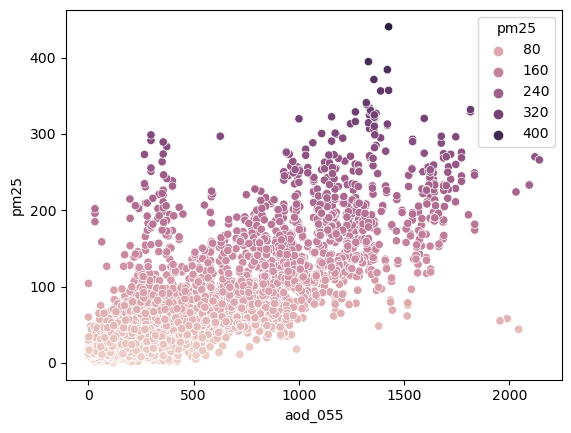

In [53]:
sns.scatterplot(data=df_pm25, x='aod_055', y='pm25', hue='pm25')

## Model Training

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

# Load your sample DataFrame (replace with your actual data)
# Assuming your DataFrame is named 'df' and contains columns 'pm25', 'aod_055', and 'dem'
# You can replace the sample data with your actual data




### Fitting OLS

In [55]:


# Define features (X) and target (y)
X = df_pm25[['aod_055', ]]
y = df_pm25['pm25']


# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import statsmodels.api as sm

# Fit OLS model
X_train_ols = sm.add_constant(X_train)  # Add constant term
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Get summary of OLS model
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                 1.244e+04
Date:                Sun, 28 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:33:06   Log-Likelihood:                -36841.
No. Observations:                7590   AIC:                         7.369e+04
Df Residuals:                    7588   BIC:                         7.370e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0834      0.499     24.192      0.0

In [56]:

# Add constant term to test data
X_test_ols = sm.add_constant(X_test)

# Predict pm25 values
y_pred = ols_model.predict(X_test_ols)

# Evaluate the model (optional)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 33.73
R-squared: 0.62


## Predict grid in Chiangmai 

### Load Chiangmai grid & DEM

In [57]:

df_chiangmai_dem = pd.read_parquet(r'..\data\df_chiangmai_dem.parquet')
df_chiangmai_joined = df_chiangmai_grid.merge(df_chiangmai_dem, how='inner', left_index=True, right_index=True)
df_chiangmai_joined



,lat,lon,dem
grid_id,,,
62620,17.2576,98.4170,756.0
62621,17.2576,98.4259,748.0
62622,17.2576,98.4349,813.0
62623,17.2576,98.4439,911.0
63065,17.2666,98.4080,879.0
...,...,...,...
205907,20.1412,99.5039,1424.0
205908,20.1412,99.5129,1234.0
205909,20.1412,99.5219,1286.0


In [58]:
dir_predicted_pm25_root = r'../data/predicted_pm25_chiangmai_v2'
dir_predicted_pm25_daily = os.path.join(dir_predicted_pm25_root, 'daily')
dir_predicted_pm25_monthly = os.path.join(dir_predicted_pm25_root, 'monthly')
io_tools.create_folders(dir_predicted_pm25_daily, dir_predicted_pm25_monthly)


## Predict

In [59]:
dir_chiangmai_aod_daily = r'../data/chiangmai_aod_daily'
list_file_aod_daily = io_tools.get_list_files(dir_chiangmai_aod_daily, '.parquet$')
pbar_aod_daily = tqdm(list_file_aod_daily)
# rerun = input('Rerun? (Y/N)')
rerun = 'Y'
if rerun.upper()=='Y':
    rerun_f = True
else:
    rerun_f = False

for path_aod_daily in pbar_aod_daily:
    
    year_month = os.path.basename(path_aod_daily)[23:30]
    tile_id = os.path.basename(path_aod_daily)[31:37]
    
    path_out_daily = os.path.join(dir_predicted_pm25_daily, f'df_predict_pm25-{year_month}-{tile_id}.parquet')

    if os.path.exists(path_out_daily):
        if not rerun_f:
            continue

    df_aod_daily = pd.read_parquet(path_aod_daily)
    del(df_aod_daily['year_month'])
    del(df_aod_daily['tile_id'])
    df_predict_pm25 = pd.melt(df_aod_daily, ignore_index=False, )
    df_predict_pm25 = df_predict_pm25.dropna().copy()
    df_predict_pm25 = df_predict_pm25.rename(columns={'variable':'date', 'value':'aod_055'})
    df_predict_pm25 = df_chiangmai_dem.merge(df_predict_pm25, how='inner', left_index=True, right_index=True) 
    X_predict = df_predict_pm25[['aod_055', 'dem']]


    #OLS
    X_predict = df_predict_pm25[['aod_055',]]
    X_predict_ols = sm.add_constant(X_predict)
    y_pred = ols_model.predict(X_predict_ols)

    assert(len(y_pred)) == (len(df_predict_pm25))
    df_predict_pm25['pm25_pred'] = y_pred

    df_predict_pm25 = df_predict_pm25.merge(df_chiangmai_grid, how='left', left_index=True, right_index=True).copy()
    
    df_predict_pm25.to_parquet(path_out_daily)
        

Total of 580 files have been listed.


  0%|          | 0/580 [00:00<?, ?it/s]

## Save into monthly image

In [60]:
df_list_files_predicted_daily = io_tools.get_list_files(dir_predicted_pm25_daily, 'df_predict_pm25-.*.parquet', return_df=True)
df_list_files_predicted_daily['year_month'] = df_list_files_predicted_daily['file_nm'].str.slice(16,23)
df_list_files_predicted_daily['tile_id'] = df_list_files_predicted_daily['file_nm'].str.slice(24,30)
df_list_files_predicted_daily

Total of 580 files have been listed.


,file_path,file_nm,folder_nm,file_ext,year_month,tile_id
0,../data/predicted_pm25_chiangmai_v2\daily\df_p...,df_predict_pm25-2000-02-h27v06.parquet,daily,parquet,2000-02,h27v06
1,../data/predicted_pm25_chiangmai_v2\daily\df_p...,df_predict_pm25-2000-02-h27v07.parquet,daily,parquet,2000-02,h27v07
2,../data/predicted_pm25_chiangmai_v2\daily\df_p...,df_predict_pm25-2000-03-h27v06.parquet,daily,parquet,2000-03,h27v06
3,../data/predicted_pm25_chiangmai_v2\daily\df_p...,df_predict_pm25-2000-03-h27v07.parquet,daily,parquet,2000-03,h27v07
4,../data/predicted_pm25_chiangmai_v2\daily\df_p...,df_predict_pm25-2000-04-h27v06.parquet,daily,parquet,2000-04,h27v06
...,...,...,...,...,...,...
575,../data/predicted_pm25_chiangmai_v2\daily\df_p...,df_predict_pm25-2024-02-h27v07.parquet,daily,parquet,2024-02,h27v07
576,../data/predicted_pm25_chiangmai_v2\daily\df_p...,df_predict_pm25-2024-03-h27v06.parquet,daily,parquet,2024-03,h27v06
577,../data/predicted_pm25_chiangmai_v2\daily\df_p...,df_predict_pm25-2024-03-h27v07.parquet,daily,parquet,2024-03,h27v07
578,../data/predicted_pm25_chiangmai_v2\daily\df_p...,df_predict_pm25-2024-04-h27v06.parquet,daily,parquet,2024-04,h27v06


### Aggregate into monthly

In [61]:
#Aggregate data in each month by calculating median for each grid
list_df_predict_pm25_monthly = []
for year_month, df_list_files_curr in df_list_files_predicted_daily.groupby('year_month'):    
    df_predict_pm25 = pd.concat([pd.read_parquet(file_path) for file_path in df_list_files_curr['file_path']])    
    df_predict_pm25_monthly = df_predict_pm25.groupby(['lat', 'lon', 'dem']).agg(year_month=('pm25_pred', 'median')).rename(columns={'year_month':year_month})
    list_df_predict_pm25_monthly.append(df_predict_pm25_monthly)
df_predict_pm25_monthly = pd.concat(list_df_predict_pm25_monthly, axis=1)  

#Fill missing value from cloudy effect by Interpolation
df_predict_pm25_monthly = df_predict_pm25_monthly.interpolate(axis=1).copy()  

#Save 
df_predict_pm25_monthly.to_parquet(r'../data/df_predict_pm25_monthly_v2.parquet')